In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import matplotlib.cm as cm
import pandas as pd
import os
from scipy import stats

from astropy.io import fits
from astropy.stats import mad_std
from astropy.cosmology import WMAP9 as cosmol

import seaborn as sea

import aplpy
from astropy.nddata.utils import Cutout2D
from astropy.wcs import WCS

import runningGALFIT as rg

In [2]:
df = pd.read_csv('/Users/rosaliaobrien/research/GALFIT_CLEAR/running_GALFIT/output_data.csv')

In [3]:
df.sort_values(by='sersic_index_850')['sersic_index_850']
# df = df.drop([29,31,17,45,0,48])

75     0.9173
91     0.9194
26     0.9967
55     1.2520
49     1.7630
       ...   
46     8.8204
15     9.5519
3     13.5903
89    19.7106
56    19.9999
Name: sersic_index_850, Length: 94, dtype: float64

In [4]:
df.columns

Index(['gid', 'mag_160', 'radius_160', 'sersic_index_160', 'axis_ratio_160',
       'PA_160', 'circ_radius_160', 'mag_125', 'radius_125',
       'sersic_index_125', 'axis_ratio_125', 'PA_125', 'circ_radius_125',
       'mag_850', 'radius_850', 'sersic_index_850', 'axis_ratio_850', 'PA_850',
       'circ_radius_850', '850-160', '125-160', 'Field', '850-160_arcsec',
       '125-160_arcsec', 'ID', 'zgrism', 'e_zgrism', 'E_zgrism', 'logMgrism',
       'e_logMgrism', 'E_logMgrism', 'logsSFR', 'e_logsSFR', 'E_logsSFR',
       'Avmag', 'e_Avmag', 'E_Avmag', 'logS1', 'e_logS1', 'E_logS1', 'tQ',
       'e_tQ', 'E_tQ', 'z50', 'e_z50', 'E_z50', 'field', 't50',
       'kpc_proper_per_arcmin', 'radius850_arcsec', 'radius850_kpc',
       'radius125_arcsec', 'radius125_kpc', 'radius160_arcsec',
       'radius160_kpc', '850-160_kpc', '125-160_kpc', 'unc_850-160_kpc',
       'unc_125-160_kpc'],
      dtype='object')

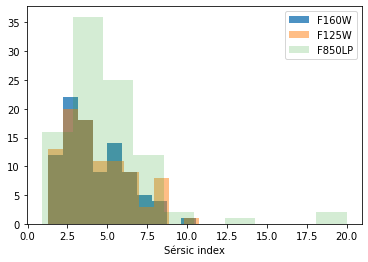

In [5]:
plt.hist(df['sersic_index_160'], alpha = 0.8, label = 'F160W')
plt.hist(df['sersic_index_125'], alpha = 0.5, label = 'F125W')
plt.hist(df['sersic_index_850'], alpha = 0.2, label = 'F850LP')

plt.xlabel('Sérsic index')
plt.legend()
plt.show()

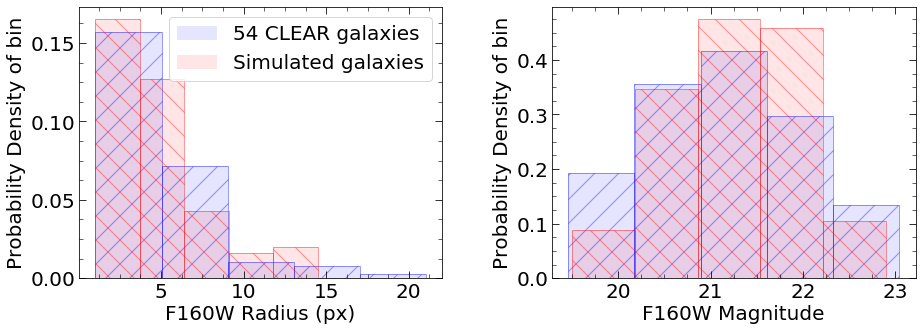

In [6]:
plt.rcParams.update({'font.size': 20})
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
plt.subplots_adjust(wspace=0.3)

sim_df = pd.read_csv('/Users/rosaliaobrien/research/GALFIT_CLEAR/running_GALFIT/models/input_params.csv')

ax1.hist(df['radius_160'], bins = 5, color = 'blue', alpha = 0.1, density = True, label = '54 CLEAR galaxies')
ax1.hist(sim_df['true_rad160'], bins = 5, color = 'red', alpha = 0.1, density = True, label = 'Simulated galaxies')

ax1.hist(df['radius_160'], bins = 5, alpha = 0.4, density = True, hatch = '/', edgecolor = 'blue', facecolor = 'None')
ax1.hist(sim_df['true_rad160'], bins = 5,alpha = 0.4, density = True, hatch = '\\', edgecolor = 'red', facecolor = 'None')

ax1.set_xlabel('F160W Radius (px)')

ax2.hist(df['mag_160'], bins = 5, color = 'blue', alpha = 0.1, density = True, label = '54 CLEAR galaxies')
ax2.hist(sim_df['true_mag'], bins = 5, color = 'red', alpha = 0.1, density = True, label = 'Simulated galaxies')

ax2.hist(df['mag_160'], bins = 5, alpha = 0.4, density = True, hatch = '/', edgecolor = 'blue', facecolor = 'None')
ax2.hist(sim_df['true_mag'], bins = 5,alpha = 0.4, density = True, hatch = '\\', edgecolor = 'red', facecolor = 'None')

ax2.set_xlabel('F160W Magnitude')

# ax.xaxis.set_minor_locator(AutoMinorLocator())

for ax in [ax1, ax2]:
    ax.set_ylabel('Probability Density of bin')
    ax.tick_params(right = True, top=True, direction = 'in', which = 'major', length = 7)
    ax.tick_params(right = True, top=True, direction = 'in', which = 'minor', length = 4)
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    
ax1.legend()
    
plt.savefig('/Users/rosaliaobrien/research/GALFIT_CLEAR/running_GALFIT/pngs/output_hist.pdf', bbox_inches = 'tight')

plt.show()

In [6]:
def bin_data_equalsize(ztype, number_of_bins, new_column_name):

    ogbinsize = int(len(df)/number_of_bins)
    remainder = len(df)%number_of_bins
    remainderlist = list(range(len(df)%number_of_bins))
    
#     print(remainderlist)

    conds = []
    bins = []
    for i in range(0,number_of_bins):

        if not remainder == 0:
            if i in remainderlist:
                binsize = ogbinsize+1
                lower = min(df.sort_values(by=ztype).iloc[binsize*i:binsize+binsize*i][ztype])
                upper = max(df.sort_values(by=ztype).iloc[binsize*i:binsize+binsize*i][ztype])
#                 print(binsize*i,binsize+binsize*i)
                prevupper = binsize+binsize*i
            else:
                lower = min(df.sort_values(by=ztype).iloc[prevupper:prevupper+ogbinsize][ztype])
                upper = max(df.sort_values(by=ztype).iloc[prevupper:prevupper+ogbinsize][ztype])
#                 print(prevupper,prevupper+ogbinsize)
                prevupper = prevupper+ogbinsize

        else:
            lower = min(df.sort_values(by=ztype).iloc[ogbinsize*i:ogbinsize+ogbinsize*i][ztype])
            upper = max(df.sort_values(by=ztype).iloc[ogbinsize*i:ogbinsize+ogbinsize*i][ztype])
#             print(ogbinsize*i,ogbinsize+ogbinsize*i)
            
#         print(lower,upper)

        cond = (df[ztype]>=lower) & (df[ztype]<=upper)
        conds.append(cond)

        lowerstr = '{:.3}'.format(lower)
        upperstr = '{:.3}'.format(upper)
        fullstr = lowerstr+'-'+upperstr
        bins.append(fullstr)

    df[new_column_name] = np.select(conds, bins)

    total_objs = []
    for cond in conds:
        print(len(df[cond][ztype]))
        total_objs.append(len(df[cond][ztype]))
    print('Total # of objects: {}'.format((sum(total_objs))))
    
    return bins

def bin_data_equalsp(ztype, number_of_bins, new_column_name):

    t = (max(df[ztype])-min(df[ztype]))/number_of_bins
    start_cond = min(df[ztype])

    conds = []
    bins = []
    for i in range(0,number_of_bins):
        cond = (df[ztype]>=start_cond+t*i) & (df[ztype]<=start_cond+(i+1)*t)
        conds.append(cond)

        binnum = '{:.3}-{:.3}'.format(start_cond+t*i, start_cond+(i+1)*t)
        bins.append(binnum)

    df[new_column_name] = np.select(conds, bins)

    total_obs = 0
    for cond in conds:
        l = len(df[cond][new_column_name])
        print(l)
        total_obs +=l
    print('Total # of objects:',total_obs)
    print('\n')
    
    return bins

In [7]:
print('---zgrism---')
zgrism_bins_4 = bin_data_equalsize('zgrism', 4,'zgrism_bin')
print('---z50---')
z50_bins_4 = bin_data_equalsize('z50', 4,'z50_bin')
print('---t50---')
t50_bins_4 = bin_data_equalsize('t50', 4,'t50_bin')

print('---zgrism---')
zgrism_bins_more = bin_data_equalsize('zgrism', 6,'zgrism_bin_more')
print('---z50---')
z50_bins_more = bin_data_equalsize('z50', 6,'z50_bin_more')
print('---t50---')
t50_bins_more = bin_data_equalsize('t50', 6,'t50_bin_more')

print('---zgrism---')
zgrism_bins_less = bin_data_equalsize('zgrism',3, 'zgrism_bin_less')
print('---z50---')
z50_bins_less = bin_data_equalsize('z50',3, 'z50_bin_less')
print('---t50---')
t50_bins_less = bin_data_equalsize('t50',3, 't50_bin_less')

---zgrism---
24
24
23
23
Total # of objects: 94
---z50---
27
26
29
24
Total # of objects: 106
---t50---
24
24
23
23
Total # of objects: 94
---zgrism---
17
18
19
17
16
15
Total # of objects: 102
---z50---
17
20
18
20
15
15
Total # of objects: 105
---t50---
16
16
16
16
15
15
Total # of objects: 94
---zgrism---
33
34
31
Total # of objects: 98
---z50---
34
33
32
Total # of objects: 99
---t50---
32
31
31
Total # of objects: 94


In [8]:
print('---zgrism---')
zgrism_bins_4_equalsp = bin_data_equalsp('zgrism', 4,'zgrism_bin_equalsp')
print('---z50---')
z50_bins_4_equalsp = bin_data_equalsp('z50', 4,'z50_bin_equalsp')
print('---t50---')
t50_bins_4_equalsp = bin_data_equalsp('t50', 4,'t50_bin_equalsp')

print('---zgrism---')
zgrism_bins_more_equalsp = bin_data_equalsp('zgrism', 6,'zgrism_bin_more_equalsp')
print('---z50---')
z50_bins_more_equalsp = bin_data_equalsp('z50', 6,'z50_bin_more_equalsp')
print('---t50---')
t50_bins_more_equalsp = bin_data_equalsp('t50', 6,'t50_bin_more_equalsp')

print('---zgrism---')
zgrism_bins_less_equalsp = bin_data_equalsp('zgrism',3, 'zgrism_bin_less_equalsp')
print('---z50---')
z50_bins_less_equalsp = bin_data_equalsp('z50',3, 'z50_bin_less_equalsp')
print('---t50---')
t50_bins_less_equalsp = bin_data_equalsp('t50',3, 't50_bin_less_equalsp')

---zgrism---
43
28
14
9
Total # of objects: 94


---z50---
53
31
6
4
Total # of objects: 94


---t50---
18
33
29
14
Total # of objects: 94


---zgrism---
28
34
10
10
7
6
Total # of objects: 95


---z50---
27
37
20
6
2
2
Total # of objects: 94


---t50---
7
18
26
17
17
9
Total # of objects: 94


---zgrism---
62
20
13
Total # of objects: 95


---z50---
64
26
4
Total # of objects: 94


---t50---
25
43
26
Total # of objects: 94




In [9]:
# meankpc0_850 = df.loc[df['zgrism_bin'] == zgrism_bins[0]].mean(0)['850-160_kpc']
# meankpc1_850 = df.loc[df['zgrism_bin'] == zgrism_bins[1]].mean(0)['850-160_kpc']
# meankpc2_850 = df.loc[df['zgrism_bin'] == zgrism_bins[2]].mean(0)['850-160_kpc']
# meankpc3_850 = df.loc[df['zgrism_bin'] == zgrism_bins[3]].mean(0)['850-160_kpc']

# meankpc0_125 = df.loc[df['zgrism_bin'] == zgrism_bins[0]].mean(0)['125-160_kpc']
# meankpc1_125 = df.loc[df['zgrism_bin'] == zgrism_bins[1]].mean(0)['125-160_kpc']
# meankpc2_125 = df.loc[df['zgrism_bin'] == zgrism_bins[2]].mean(0)['125-160_kpc']
# meankpc3_125 = df.loc[df['zgrism_bin'] == zgrism_bins[3]].mean(0)['125-160_kpc']

unc0_rad850 = mad_std(df.loc[df['zgrism_bin'] == zgrism_bins_4[0]]['850-160_kpc'])/np.sqrt(len(df.loc[df['zgrism_bin'] == zgrism_bins_4[0]]['850-160_kpc']))
unc1_rad850 = mad_std(df.loc[df['zgrism_bin'] == zgrism_bins_4[1]]['850-160_kpc'])/np.sqrt(len(df.loc[df['zgrism_bin'] == zgrism_bins_4[1]]['850-160_kpc']))
unc2_rad850 = mad_std(df.loc[df['zgrism_bin'] == zgrism_bins_4[2]]['850-160_kpc'])/np.sqrt(len(df.loc[df['zgrism_bin'] == zgrism_bins_4[2]]['850-160_kpc']))
unc3_rad850 = mad_std(df.loc[df['zgrism_bin'] == zgrism_bins_4[3]]['850-160_kpc'])/np.sqrt(len(df.loc[df['zgrism_bin'] == zgrism_bins_4[3]]['850-160_kpc']))

unc0_rad125 = mad_std(df.loc[df['zgrism_bin'] == zgrism_bins_4[0]]['125-160_kpc'])/np.sqrt(len(df.loc[df['zgrism_bin'] == zgrism_bins_4[0]]['125-160_kpc']))
unc1_rad125 = mad_std(df.loc[df['zgrism_bin'] == zgrism_bins_4[1]]['125-160_kpc'])/np.sqrt(len(df.loc[df['zgrism_bin'] == zgrism_bins_4[1]]['125-160_kpc']))
unc2_rad125 = mad_std(df.loc[df['zgrism_bin'] == zgrism_bins_4[2]]['125-160_kpc'])/np.sqrt(len(df.loc[df['zgrism_bin'] == zgrism_bins_4[2]]['125-160_kpc']))
unc3_rad125 = mad_std(df.loc[df['zgrism_bin'] == zgrism_bins_4[3]]['125-160_kpc'])/np.sqrt(len(df.loc[df['zgrism_bin'] == zgrism_bins_4[3]]['125-160_kpc']))

median0_850 = df.loc[df['zgrism_bin'] == zgrism_bins_4[0]].median(0)['850-160_kpc']
median1_850 = df.loc[df['zgrism_bin'] == zgrism_bins_4[1]].median(0)['850-160_kpc']
median2_850 = df.loc[df['zgrism_bin'] == zgrism_bins_4[2]].median(0)['850-160_kpc']
median3_850 = df.loc[df['zgrism_bin'] == zgrism_bins_4[3]].median(0)['850-160_kpc']

median0_125 = df.loc[df['zgrism_bin'] == zgrism_bins_4[0]].median(0)['125-160_kpc']
median1_125 = df.loc[df['zgrism_bin'] == zgrism_bins_4[1]].median(0)['125-160_kpc']
median2_125 = df.loc[df['zgrism_bin'] == zgrism_bins_4[2]].median(0)['125-160_kpc']
median3_125 = df.loc[df['zgrism_bin'] == zgrism_bins_4[3]].median(0)['125-160_kpc']

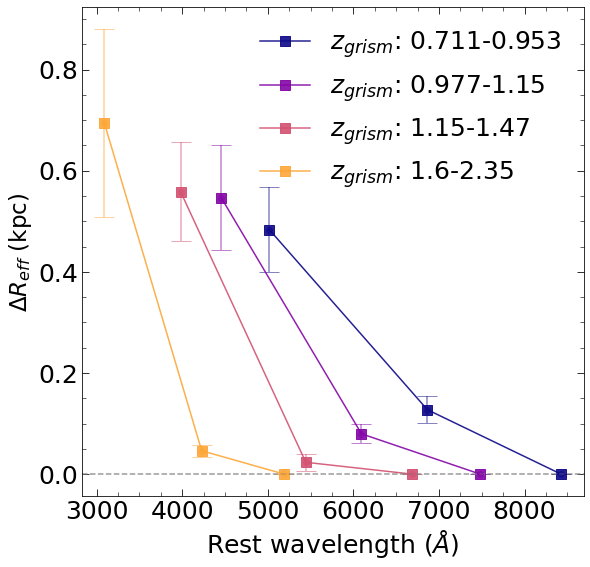

In [10]:
# %matplotlib notebook
plt.rcParams.update({'font.size': 25})

fig,ax = plt.subplots(1, figsize=(9,9))

#http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?id=HST/WFC3_IR.F160W
F160W_meanlam = 15436.3 #angstroms
F125W_meanlam = 12576.2 #angstroms
F850LP_meanlam = 9193.8 #angstroms

lst850 = [median0_850,median1_850,median2_850,median3_850]
lst125 = [median0_125,median1_125,median2_125,median3_125]
labels = zgrism_bins_4
mean_rdshft = [eval(labels[0].split('-')[0]+'+'+labels[0].split('-')[1])/2,
              eval(labels[1].split('-')[0]+'+'+labels[1].split('-')[1])/2,
              eval(labels[2].split('-')[0]+'+'+labels[2].split('-')[1])/2,
              eval(labels[3].split('-')[0]+'+'+labels[3].split('-')[1])/2]
unc850_list = [unc0_rad850,unc1_rad850,unc2_rad850,unc3_rad850]
unc125_list = [unc0_rad125,unc1_rad125,unc2_rad125,unc3_rad125]
colors=cm.plasma(np.linspace(0, 0.8, 4))
for m850, m125, color, label, mean_r, u850, u125 in zip(lst850, lst125, colors, labels, mean_rdshft, unc850_list, unc125_list):
    pt850 = F850LP_meanlam/(1+mean_r)
    pt125 = F125W_meanlam/(1+mean_r)
    pt160 = F160W_meanlam/(1+mean_r)
    ax.plot([pt850,pt125,pt160], [m850, m125, 0], color=color, alpha = 0.9, marker = 's', markersize = 10, label = '$z_{grism}$:'+' {l}'.format(l=label))
    ax.errorbar([pt850,pt125,pt160], [m850, m125, 0], [u850, u125, 0], fmt='o', color=color, alpha=0.5, capsize = 10)

ax.set_ylabel('$\Delta R_{eff}$ (kpc)', size=23)
ax.set_xlabel('Rest wavelength ($\AA$)')
ax.axhline(y=0, color='grey', alpha = 0.8, linestyle = '--')

plt.legend(loc='upper right', frameon = False)

#FWHM taken from: https://www.stsci.edu/itt/review/ihb_cy17/WFC3/c07_ir7.html
#wavelengths for filter taken from: https://www.stsci.edu/itt/review/ihb_cy17/WFC3/c07_ir6.html

# F160W = (0.153+0.148)/2
# F125W = (0.138+0.134)/2
# LP850 = 0.128

# rest160 = F160W/60*cosmol.kpc_proper_per_arcmin(1.4).value/2.355
# rest125 = F125W/60*cosmol.kpc_proper_per_arcmin(1.4).value/2.355
# rest850 = LP850/60*cosmol.kpc_proper_per_arcmin(1.4).value/2.355

# ax.axhline(y=rest850, color='grey', linestyle = 'dotted', alpha=0.5, label = 'F850LP - F160W PSF FWHM')
# ax.axhline(y=rest160, color='grey', linestyle = 'dotted', alpha=0.5, label = 'F125W - F160W PSF FWHM')
# ax.axhline(y=rest125, color='grey', linestyle = 'dotted', alpha=0.5, label = 'F125W - F160W PSF FWHM')

# plt.title('Median change in effective radius \n for different redshift bins')

plt.tick_params(right = True, top=True, direction = 'in', which = 'major', length = 7)
plt.tick_params(right = True, top=True, direction = 'in', which = 'minor', length = 4)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))

plt.savefig('/Users/rosaliaobrien/research/GALFIT_CLEAR/running_GALFIT/pngs/dReff_zgrismbins_median.pdf', bbox_inches = 'tight')
plt.show()

In [11]:
def refftrend_plots(binamt = 4, bintype = 'equal amount', zgrism_ylim = 1.5, z50_ylim = 1.5, t50_ylim = 1.5,
                   zgrism_ylim_bot = 0, z50_ylim_bot = 0, t50_ylim_bot = 0):
    
    if bintype == 'equally spaced':
        
        if binamt == 3:
            zgrism_bins = zgrism_bins_less_equalsp
            z50_bins = z50_bins_less_equalsp
            t50_bins = t50_bins_less_equalsp

            zgrism_col = 'zgrism_bin_less_equalsp'
            z50_col = 'z50_bin_less_equalsp'
            t50_col = 't50_bin_less_equalsp'

        if binamt == 6:
            zgrism_bins = zgrism_bins_more_equalsp
            z50_bins = z50_bins_more_equalsp
            t50_bins = t50_bins_more_equalsp

            zgrism_col = 'zgrism_bin_more_equalsp'
            z50_col = 'z50_bin_more_equalsp'
            t50_col = 't50_bin_more_equalsp'

        if binamt == 4:
            zgrism_bins = zgrism_bins_4_equalsp
            z50_bins = z50_bins_4_equalsp
            t50_bins = t50_bins_4_equalsp

            zgrism_col = 'zgrism_bin_equalsp'
            z50_col = 'z50_bin_equalsp'
            t50_col = 't50_bin_equalsp'
        
    if bintype == 'equal amount':
    
        if binamt == 3:
            zgrism_bins = zgrism_bins_less
            z50_bins = z50_bins_less
            t50_bins = t50_bins_less

            zgrism_col = 'zgrism_bin_less'
            z50_col = 'z50_bin_less'
            t50_col = 't50_bin_less'

        if binamt == 6:
            zgrism_bins = zgrism_bins_more
            z50_bins = z50_bins_more
            t50_bins = t50_bins_more

            zgrism_col = 'zgrism_bin_more'
            z50_col = 'z50_bin_more'
            t50_col = 't50_bin_more'

        if binamt == 4:
            zgrism_bins = zgrism_bins_4
            z50_bins = z50_bins_4
            t50_bins = t50_bins_4

            zgrism_col = 'zgrism_bin'
            z50_col = 'z50_bin'
            t50_col = 't50_bin'
    
    plt.rcParams.update({'font.size': 20})
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,5))
    
    ax1.scatter(df['zgrism'], df['850-160_kpc'], color = 'lightblue', alpha = 0.4)
    ax2.scatter(df['z50'], df['850-160_kpc'], color = 'lightblue', alpha = 0.4)
    ax3.scatter(df['t50'], df['850-160_kpc'], color = 'lightblue', alpha = 0.4)
    
    mean_zg_list = []
    mean_zf_list = []
    mean_tf_list = []
    med_zg_list = []
    med_zf_list = []
    med_tf_list = []
    
    unc_zg_list = []
    unc_zf_list = []
    unc_tf_list = []

    colors=cm.plasma(np.linspace(0, 0.8, len(zgrism_bins)))
    colors2=cm.viridis(np.linspace(0, 0.8,len(zgrism_bins)))
    colors3=cm.hsv(np.linspace(0.7, 1,len(zgrism_bins)))

    for i in range(0,len(zgrism_bins)):
        unc_zg = mad_std(df.loc[df[zgrism_col] == zgrism_bins[i]]['850-160_kpc'])/np.sqrt(len(df.loc[df[zgrism_col] == zgrism_bins[i]]['850-160_kpc']))
        unc_zf = mad_std(df.loc[df[z50_col] == z50_bins[i]]['850-160_kpc'])/np.sqrt(len(df.loc[df[z50_col] == z50_bins[i]]['850-160_kpc']))
        unc_tf = mad_std(df.loc[df[t50_col] == t50_bins[i]]['850-160_kpc'])/np.sqrt(len(df.loc[df[t50_col] == t50_bins[i]]['850-160_kpc']))
        mean_zg = df.loc[df[zgrism_col] == zgrism_bins[i]].mean(0)['zgrism']
        mean_zf = df.loc[df[z50_col] == z50_bins[i]].mean(0)['z50']
        mean_tf = df.loc[df[t50_col] == t50_bins[i]].mean(0)['t50']
        med_zg = df.loc[df[zgrism_col] == zgrism_bins[i]].median(0)['850-160_kpc']
        med_zf = df.loc[df[z50_col] == z50_bins[i]].median(0)['850-160_kpc']
        med_tf = df.loc[df[t50_col] == t50_bins[i]].median(0)['850-160_kpc']

        mean_zg_list.append(mean_zg)
        mean_zf_list.append(mean_zf)
        mean_tf_list.append(mean_tf)
        med_zg_list.append(med_zg)
        med_zf_list.append(med_zf)
        med_tf_list.append(med_tf)
        unc_zg_list.append(unc_zg)
        unc_zf_list.append(unc_zf)
        unc_tf_list.append(unc_tf)

        ax1.errorbar(mean_zg, med_zg, unc_zg, fmt='o', markersize=7, marker = 's', capsize = 5, c = colors[i], label = '$z_{grism}:$'+'{}'.format(zgrism_bins[i]))
        ax2.errorbar(mean_zf, med_zf, unc_zf, fmt='o', markersize=7, marker = 's', capsize = 5, c = colors2[i], label = '$z_{50}:$'+'{}'.format(z50_bins[i]))
        ax3.errorbar(mean_tf, med_tf, unc_tf, fmt='o', markersize=7, marker = 's', capsize = 5, c = colors3[i], label = '$t_{50}:$'+'{}'.format(t50_bins[i]))
        
        
    mean_zf_list = np.array(mean_zf_list)
    med_zf_list = np.array(med_zf_list)
    mean_zf_list = mean_zf_list[~np.isnan(mean_zf_list)]
    med_zf_list = med_zf_list[~np.isnan(med_zf_list)]

    ###Plot the lines###
    slope, intercept, r_value, p_value, std_err = stats.linregress(mean_zg_list,med_zg_list)
    xspace = np.linspace(0.8, 2)
    ax1.plot(xspace, slope*xspace+intercept,  color='grey', alpha = 0.5)
    ax1.fill_between(xspace, slope*xspace+intercept-std_err,slope*xspace+intercept+std_err,  color='grey', alpha = 0.08)
    slope_zg = slope
    intercept_zg = intercept
#     ax1ybot = slope*0.9+intercept-std_err
#     print('slope = {:.2}'.format(slope))

    slope, intercept, r_value, p_value, std_err_zf = stats.linregress(mean_zf_list,med_zf_list)
    xspace = np.linspace(2, 11)
    ax2.plot(xspace, slope*xspace+intercept,  color='grey', alpha = 0.5)
    ax2.fill_between(xspace, slope*xspace+intercept-std_err,slope*xspace+intercept+std_err,  color='grey', alpha = 0.08)
    slope_zf = slope
    intercept_zf = intercept
#     ax2ybot = slope*2+intercept-std_err
#     print('slope = {:.2}'.format(slope))

    slope, intercept, r_value, p_value, std_err_tf = stats.linregress(mean_tf_list,med_tf_list)
    xspace = np.linspace(2, 5)
    ax3.plot(xspace, slope*xspace+intercept,  color='grey', alpha = 0.5)
    ax3.fill_between(xspace, slope*xspace+intercept-std_err,slope*xspace+intercept+std_err,  color='grey', alpha = 0.08)
    slope_tf = slope
    intercept_tf = intercept
#     ax3ybot = slope*2+intercept-std_err
#     print('slope = {:.2}'.format(slope))
    
    ###Labeling###

    xlabels = ['$z_{grism}$','$z_{50}$','$t_{50}$']
    for index, ax in enumerate([ax1, ax2, ax3]):
        ax.yaxis.set_tick_params(labelleft=True)
        ax.tick_params(right = True, top=True, direction = 'in', which = 'major', length = 7)
        ax.tick_params(right = True, top=True, direction = 'in', which = 'minor', length = 4)
        ax.xaxis.set_minor_locator(AutoMinorLocator(4))
        ax.yaxis.set_minor_locator(AutoMinorLocator(4))
        ax.legend(ncol = 1, fontsize = 'x-small', frameon = False, loc = 'upper left')
        ax.set_ylabel(r'$\Delta R_{eff, \mathrm{F850LP}}$ (kpc)')
        ax.set_xlabel('{}'.format(xlabels[index]))
        
    ax3.set_xlabel('$t_{50}$'+' (Gyr)')

    # plt.suptitle('Equal sized bins')

    plt.subplots_adjust(wspace=0.3)

    ax1.set_ylim(top = zgrism_ylim, bottom = zgrism_ylim_bot)
    ax2.set_ylim(top = z50_ylim, bottom = z50_ylim_bot)
    ax3.set_ylim(top = t50_ylim, bottom = t50_ylim_bot)
    
#     ax3.legend(loc = 'upper left', ncol = 1, fontsize = 'x-small', frameon = False)
#     ax2.legend(loc = 'upper right', ncol = 1, fontsize = 'x-small', frameon = False)

    if bintype == 'equal amount':
        ax1.set_xlim(left = 0.9, right = 1.7)
        ax2.set_xlim(left = 2, right = 6.7)
        ax3.set_xlim(left = 2, right = 4.7)
        plt.savefig('/Users/rosaliaobrien/research/GALFIT_CLEAR/running_GALFIT/pngs/medradtrends_same#objsperbin_'+str(binamt)+'bins.pdf', bbox_inches = 'tight')
        
    if bintype == 'equally spaced':
        ax1.set_xlim(left = 0.9, right = 1.8)
        ax2.set_xlim(left = 2, right = 10)
        ax3.set_xlim(left = 2, right = 4.8)
        plt.savefig('/Users/rosaliaobrien/research/GALFIT_CLEAR/running_GALFIT/pngs/medradtrends_equalsp_'+str(binamt)+'bins.pdf', bbox_inches = 'tight')

    plt.show()
    
    return slope_zg, slope_zf, slope_tf, intercept_zg, intercept_zf, intercept_tf

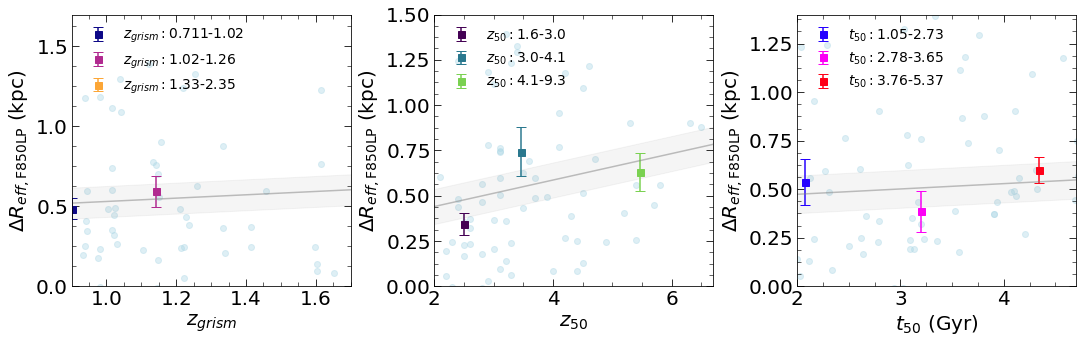

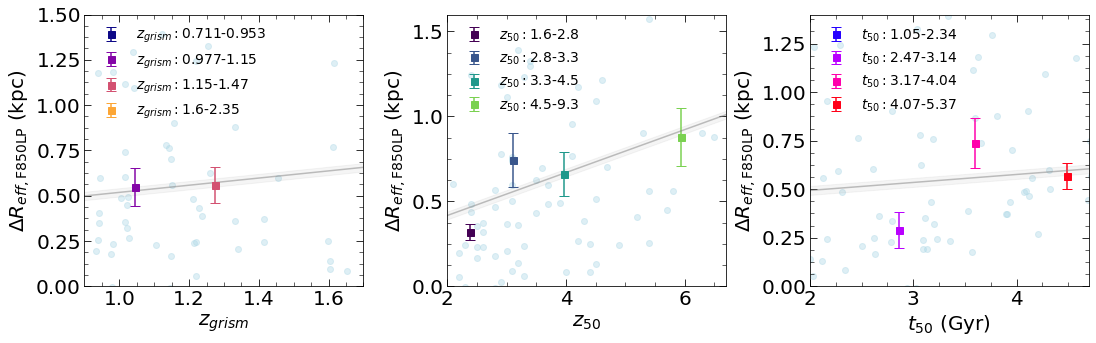

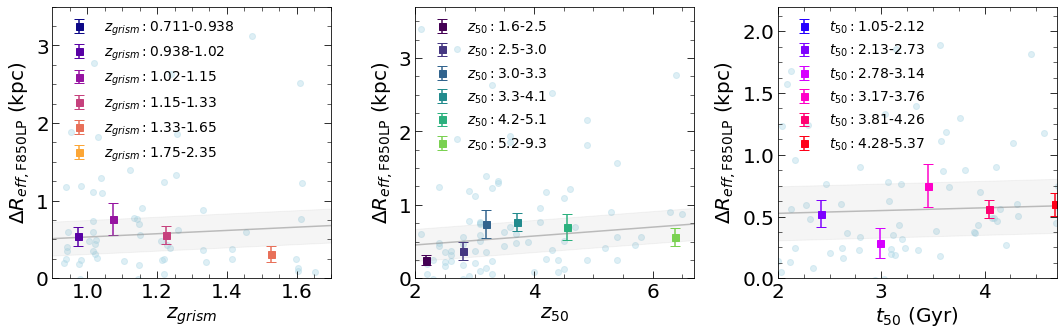

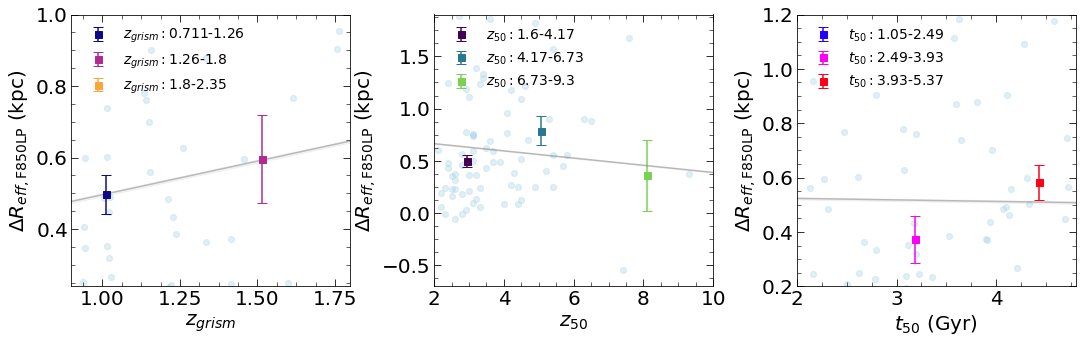

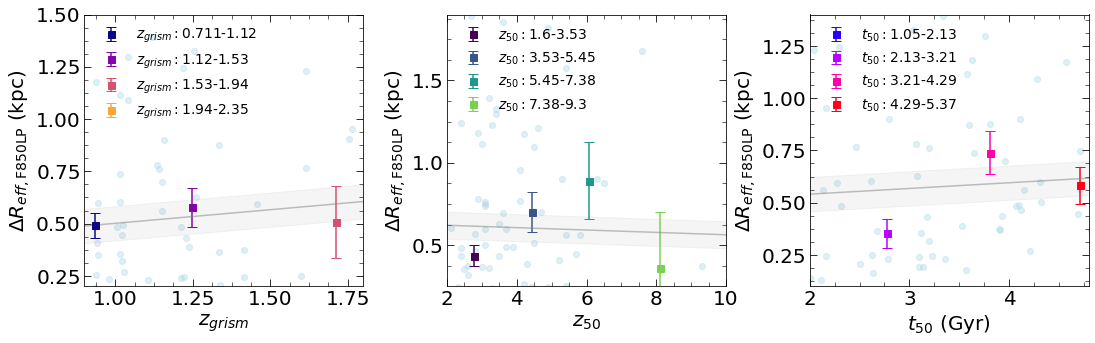

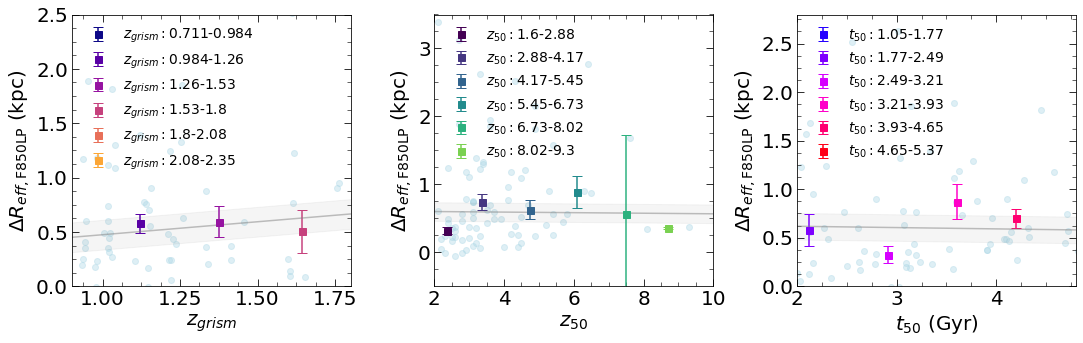

In [12]:
zgslopes = []
zfslopes = []
tfslopes = []

zgintercepts = []
zfintercepts = []
tfintercepts = []

slope_zg, slope_zf, slope_tf, intercept_zg, intercept_zf, intercept_tf = refftrend_plots(3, zgrism_ylim = 1.7, z50_ylim = 1.5, t50_ylim = 1.4, 
                                                                                        zgrism_ylim_bot = 0, z50_ylim_bot = 0, t50_ylim_bot = 0)
for slope, slopelist in zip([slope_zg,slope_zf,slope_tf], [zgslopes,zfslopes,tfslopes]):
    slopelist.append(slope)
for intercept, interceptlist in zip([intercept_zg,intercept_zf,intercept_tf], [zgintercepts,zfintercepts,tfintercepts]):
    interceptlist.append(intercept)
    
slope_zg, slope_zf, slope_tf, intercept_zg, intercept_zf, intercept_tf = refftrend_plots(4, zgrism_ylim = 1.5, z50_ylim = 1.6, t50_ylim = 1.4, 
                                                                                        zgrism_ylim_bot = 0, z50_ylim_bot = 0, t50_ylim_bot = 0)
for slope, slopelist in zip([slope_zg,slope_zf,slope_tf], [zgslopes,zfslopes,tfslopes]):
    slopelist.append(slope)
for intercept, interceptlist in zip([intercept_zg,intercept_zf,intercept_tf], [zgintercepts,zfintercepts,tfintercepts]):
    interceptlist.append(intercept)
    
slope_zg, slope_zf, slope_tf, intercept_zg, intercept_zf, intercept_tf = refftrend_plots(6, zgrism_ylim = 3.5, z50_ylim = 3.7, t50_ylim = 2.2, 
                                                                                        zgrism_ylim_bot = 0, z50_ylim_bot = 0, t50_ylim_bot = 0)
for slope, slopelist in zip([slope_zg,slope_zf,slope_tf], [zgslopes,zfslopes,tfslopes]):
    slopelist.append(slope)
for intercept, interceptlist in zip([intercept_zg,intercept_zf,intercept_tf], [zgintercepts,zfintercepts,tfintercepts]):
    interceptlist.append(intercept)

slope_zg, slope_zf, slope_tf, intercept_zg, intercept_zf, intercept_tf = refftrend_plots(3, zgrism_ylim = 1, z50_ylim = 1.9, t50_ylim = 1.2, bintype='equally spaced', 
                                                                                        zgrism_ylim_bot = 0.24, z50_ylim_bot = -0.7, t50_ylim_bot = 0.2)
for slope, slopelist in zip([slope_zg,slope_zf,slope_tf], [zgslopes,zfslopes,tfslopes]):
    slopelist.append(slope)
for intercept, interceptlist in zip([intercept_zg,intercept_zf,intercept_tf], [zgintercepts,zfintercepts,tfintercepts]):
    interceptlist.append(intercept)
    
slope_zg, slope_zf, slope_tf, intercept_zg, intercept_zf, intercept_tf = refftrend_plots(4, zgrism_ylim = 1.5, z50_ylim = 1.9, t50_ylim = 1.4, bintype='equally spaced', 
                                                                                        zgrism_ylim_bot = 0.2, z50_ylim_bot = 0.25, t50_ylim_bot = 0.1)
for slope, slopelist in zip([slope_zg,slope_zf,slope_tf], [zgslopes,zfslopes,tfslopes]):
    slopelist.append(slope)
for intercept, interceptlist in zip([intercept_zg,intercept_zf,intercept_tf], [zgintercepts,zfintercepts,tfintercepts]):
    interceptlist.append(intercept)
    
slope_zg, slope_zf, slope_tf, intercept_zg, intercept_zf, intercept_tf = refftrend_plots(6, zgrism_ylim = 2.5, z50_ylim = 3.5, t50_ylim = 2.8, bintype='equally spaced', 
                                                                                        zgrism_ylim_bot = 0, z50_ylim_bot = -0.5, t50_ylim_bot = 0)
for slope, slopelist in zip([slope_zg,slope_zf,slope_tf], [zgslopes,zfslopes,tfslopes]):
    slopelist.append(slope)
for intercept, interceptlist in zip([intercept_zg,intercept_zf,intercept_tf], [zgintercepts,zfintercepts,tfintercepts]):
    interceptlist.append(intercept)

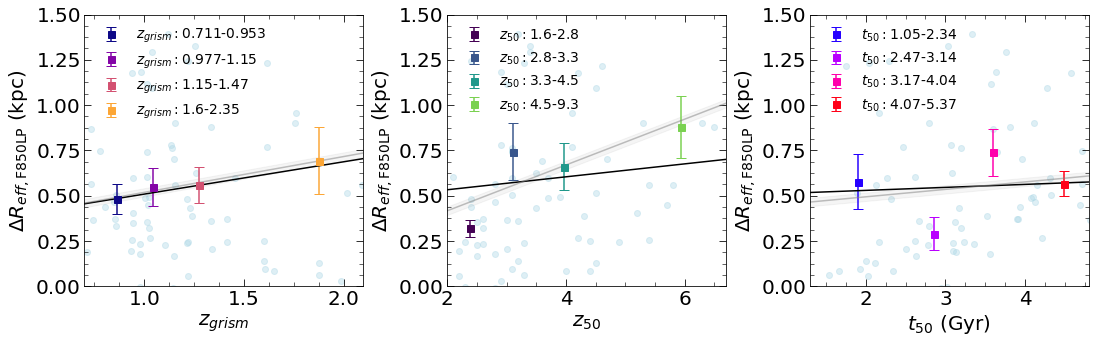

In [25]:
plt.rcParams.update({'font.size': 20})
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,5), sharey = True)

xspace = np.linspace(0.7, 2.1)
slope = sum(zgslopes)/len(zgslopes)
intercept = sum(zgintercepts)/len(zgintercepts)
ax1.plot(xspace, slope*xspace+intercept,  color='black', alpha = 1)

xspace = np.linspace(2, 11)
slope = sum(zfslopes)/len(zfslopes)
intercept = sum(zfintercepts)/len(zfintercepts)
ax2.plot(xspace, slope*xspace+intercept,  color='black', alpha = 1)

xspace = np.linspace(1, 6)
slope = sum(tfslopes)/len(tfslopes)
intercept = sum(tfintercepts)/len(tfintercepts)
ax3.plot(xspace, slope*xspace+intercept,  color='black', alpha = 1)

ax1.scatter(df['zgrism'], df['850-160_kpc'], color = 'lightblue', alpha = 0.4)
ax2.scatter(df['z50'], df['850-160_kpc'], color = 'lightblue', alpha = 0.4)
ax3.scatter(df['t50'], df['850-160_kpc'], color = 'lightblue', alpha = 0.4)

zgrism_bins = zgrism_bins_4
z50_bins = z50_bins_4
t50_bins = t50_bins_4

zgrism_col = 'zgrism_bin'
z50_col = 'z50_bin'
t50_col = 't50_bin'

mean_zg_list = []
mean_zf_list = []
mean_tf_list = []
med_zg_list = []
med_zf_list = []
med_tf_list = []

unc_zg_list = []
unc_zf_list = []
unc_tf_list = []

colors=cm.plasma(np.linspace(0, 0.8, len(zgrism_bins)))
colors2=cm.viridis(np.linspace(0, 0.8,len(zgrism_bins)))
colors3=cm.hsv(np.linspace(0.7, 1,len(zgrism_bins)))

for i in range(0,len(zgrism_bins)):
    unc_zg = mad_std(df.loc[df[zgrism_col] == zgrism_bins[i]]['850-160_kpc'])/np.sqrt(len(df.loc[df[zgrism_col] == zgrism_bins[i]]['850-160_kpc']))
    unc_zf = mad_std(df.loc[df[z50_col] == z50_bins[i]]['850-160_kpc'])/np.sqrt(len(df.loc[df[z50_col] == z50_bins[i]]['850-160_kpc']))
    unc_tf = mad_std(df.loc[df[t50_col] == t50_bins[i]]['850-160_kpc'])/np.sqrt(len(df.loc[df[t50_col] == t50_bins[i]]['850-160_kpc']))
    mean_zg = df.loc[df[zgrism_col] == zgrism_bins[i]].mean(0)['zgrism']
    mean_zf = df.loc[df[z50_col] == z50_bins[i]].mean(0)['z50']
    mean_tf = df.loc[df[t50_col] == t50_bins[i]].mean(0)['t50']
    med_zg = df.loc[df[zgrism_col] == zgrism_bins[i]].median(0)['850-160_kpc']
    med_zf = df.loc[df[z50_col] == z50_bins[i]].median(0)['850-160_kpc']
    med_tf = df.loc[df[t50_col] == t50_bins[i]].median(0)['850-160_kpc']

    mean_zg_list.append(mean_zg)
    mean_zf_list.append(mean_zf)
    mean_tf_list.append(mean_tf)
    med_zg_list.append(med_zg)
    med_zf_list.append(med_zf)
    med_tf_list.append(med_tf)
    unc_zg_list.append(unc_zg)
    unc_zf_list.append(unc_zf)
    unc_tf_list.append(unc_tf)

    ax1.errorbar(mean_zg, med_zg, unc_zg, fmt='o', markersize=7, marker = 's', capsize = 5, c = colors[i], label = '$z_{grism}:$'+'{}'.format(zgrism_bins[i]))
    ax2.errorbar(mean_zf, med_zf, unc_zf, fmt='o', markersize=7, marker = 's', capsize = 5, c = colors2[i], label = '$z_{50}:$'+'{}'.format(z50_bins[i]))
    ax3.errorbar(mean_tf, med_tf, unc_tf, fmt='o', markersize=7, marker = 's', capsize = 5, c = colors3[i], label = '$t_{50}:$'+'{}'.format(t50_bins[i]))


mean_zf_list = np.array(mean_zf_list)
med_zf_list = np.array(med_zf_list)
mean_zf_list = mean_zf_list[~np.isnan(mean_zf_list)]
med_zf_list = med_zf_list[~np.isnan(med_zf_list)]

###Plot the lines###
slope, intercept, r_value, p_value, std_err = stats.linregress(mean_zg_list,med_zg_list)
xspace = np.linspace(0.7, 2.1)
ax1.plot(xspace, slope*xspace+intercept,  color='grey', alpha = 0.5)
ax1.fill_between(xspace, slope*xspace+intercept-std_err,slope*xspace+intercept+std_err,  color='grey', alpha = 0.08)
slope_zg = slope
intercept_zg = intercept
#     print('slope = {:.2}'.format(slope))

slope, intercept, r_value, p_value, std_err_zf = stats.linregress(mean_zf_list,med_zf_list)
xspace = np.linspace(2, 11)
ax2.plot(xspace, slope*xspace+intercept,  color='grey', alpha = 0.5)
ax2.fill_between(xspace, slope*xspace+intercept-std_err,slope*xspace+intercept+std_err,  color='grey', alpha = 0.08)
slope_zf = slope
intercept_zf = intercept
#     print('slope = {:.2}'.format(slope))

slope, intercept, r_value, p_value, std_err_tf = stats.linregress(mean_tf_list,med_tf_list)
xspace = np.linspace(1.3, 4.8)
ax3.plot(xspace, slope*xspace+intercept,  color='grey', alpha = 0.5)
ax3.fill_between(xspace, slope*xspace+intercept-std_err,slope*xspace+intercept+std_err,  color='grey', alpha = 0.08)
slope_tf = slope
intercept_tf = intercept
#     print('slope = {:.2}'.format(slope))

###Labeling###

xlabels = ['$z_{grism}$','$z_{50}$','$t_{50}$']
for index, ax in enumerate([ax1, ax2, ax3]):
    ax.yaxis.set_tick_params(labelleft=True)
    ax.tick_params(right = True, top=True, direction = 'in', which = 'major', length = 7)
    ax.tick_params(right = True, top=True, direction = 'in', which = 'minor', length = 4)
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.legend(ncol = 1, fontsize = 'x-small', frameon = False, loc = 'upper left')
    ax.set_ylabel(r'$\Delta R_{eff, \mathrm{F850LP}}$ (kpc)')
    ax.set_xlabel('{}'.format(xlabels[index]))

ax3.set_xlabel('$t_{50}$'+' (Gyr)')

plt.subplots_adjust(wspace=0.3)

ax1.set_ylim(top = 1.5, bottom = 0)
ax2.set_ylim(top = 1.5, bottom = 0)
ax3.set_ylim(top = 1.5, bottom = 0)

ax1.set_xlim(left = 0.7, right = 2.1)
ax2.set_xlim(left = 2, right = 6.7)
ax3.set_xlim(left = 1.3, right = 4.8)
plt.savefig('/Users/rosaliaobrien/research/GALFIT_CLEAR/running_GALFIT/pngs/WITHAVGSLOPES_medradtrends_same#objsperbin_'+str(4)+'bins.pdf', bbox_inches = 'tight')

plt.show()

In [14]:
# plt.rcParams.update({'font.size': 20})

# fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,5))
# plt.subplots_adjust(wspace=0.5)

# zgrism_bins = zgrism_bins_more
# z50_bins = z50_bins_more
# t50_bins = t50_bins_more

# colors=cm.plasma(np.linspace(0, 0.8, len(zgrism_bins)))
# colors2=cm.viridis(np.linspace(0, 0.8,len(zgrism_bins)))
# colors3=cm.hsv(np.linspace(0.7, 1,len(zgrism_bins)))

# for index in range(0,len(zgrism_bins)):
#     ax1.scatter(y=df.loc[df['zgrism_bin_more'] == zgrism_bins[index]]['850-160_kpc'], x=df.loc[df['zgrism_bin_more'] == zgrism_bins[index]]['z_grism'], s=200, c=[colors[index]], marker = '.')
#     ax2.scatter(y=df.loc[df['z50_bin_more'] == z50_bins[index]]['850-160_kpc'], x=df.loc[df['z50_bin_more'] == z50_bins[index]]['z_50'], s=200, c=[colors2[index]], marker = '.')
#     ax3.scatter(y=df.loc[df['t50_bin_more'] == t50_bins[index]]['850-160_kpc'], x=df.loc[df['t50_bin_more'] == t50_bins[index]]['t_50'], s=200, c=[colors3[index]], marker = '.')

# ax1.axvspan(float(zgrism_bins[0].split('-')[0]), float(zgrism_bins[0].split('-')[1]), alpha=0.05, color = 'blue')
# ax1.axvspan(float(zgrism_bins[1].split('-')[0]), float(zgrism_bins[1].split('-')[1]), alpha=0.05, color = 'purple')
# ax1.axvspan(float(zgrism_bins[2].split('-')[0]), float(zgrism_bins[2].split('-')[1]), alpha=0.05, color = 'violet')
# ax1.axvspan(float(zgrism_bins[3].split('-')[0]), float(zgrism_bins[3].split('-')[1]), alpha=0.05, color = 'red')
# ax1.axvspan(float(zgrism_bins_more[4].split('-')[0]), float(zgrism_bins_more[4].split('-')[1]), alpha=0.05, color = 'orange')
# ax1.axvspan(float(zgrism_bins_more[5].split('-')[0]), float(zgrism_bins_more[5].split('-')[1]), alpha=0.05, color = 'yellow')

# ax2.axvspan(float(z50_bins[0].split('-')[0]), float(z50_bins[0].split('-')[1]), alpha=0.05, color = 'black')
# ax2.axvspan(float(z50_bins[1].split('-')[0]), float(z50_bins[1].split('-')[1]), alpha=0.05, color = 'blue')
# ax2.axvspan(float(z50_bins[2].split('-')[0]), float(z50_bins[2].split('-')[1]), alpha=0.05, color = 'teal')
# ax2.axvspan(float(z50_bins[3].split('-')[0]), float(z50_bins[3].split('-')[1]), alpha=0.05, color = 'green')
# ax2.axvspan(float(z50_bins_more[4].split('-')[0]), float(z50_bins_more[4].split('-')[1]), alpha=0.05, color = 'limegreen')
# ax2.axvspan(float(z50_bins_more[5].split('-')[0]), float(z50_bins_more[5].split('-')[1]), alpha=0.05, color = 'yellow')

# ax3.axvspan(float(t50_bins[0].split('-')[0]), float(t50_bins[0].split('-')[1]), alpha=0.05, color = 'blue')
# ax3.axvspan(float(t50_bins[1].split('-')[0]), float(t50_bins[1].split('-')[1]), alpha=0.05, color = 'purple')
# ax3.axvspan(float(t50_bins[2].split('-')[0]), float(t50_bins[2].split('-')[1]), alpha=0.05, color = 'violet')
# ax3.axvspan(float(t50_bins[3].split('-')[0]), float(t50_bins[3].split('-')[1]), alpha=0.05, color = 'pink')
# ax3.axvspan(float(t50_bins_more[4].split('-')[0]), float(t50_bins_more[4].split('-')[1]), alpha=0.05, color = 'darkred')
# ax3.axvspan(float(t50_bins_more[5].split('-')[0]), float(t50_bins_more[5].split('-')[1]), alpha=0.05, color = 'red')

# xlabels = ['$z_{grism}$','$z_{50}$','$t_{50}$']
# for index, ax in enumerate([ax1, ax2, ax3]):
#     ax.yaxis.set_tick_params(labelleft=True)
#     ax.tick_params(right = True, top=True, direction = 'in')
#     ax.set_ylabel(r'F850LP-F160W $\Delta R_{eff}$ (kpc)')
#     ax.set_xlabel('{}'.format(xlabels[index]))
#     ax.axhline(y=0, color='grey', alpha = 0.2)
    
# ax3.set_xlabel('$t_{50}$'+' (Gyr)')

# plt.savefig('/Users/rosaliaobrien/research/GALFIT_CLEAR/running_GALFIT/pngs/binselection_same#objsperbin_6bins.pdf', bbox_inches = 'tight')
# plt.show()

In [15]:
# binamt = '6'

# zgrism_bins_lst = zgrism_bins_more_equalsp
# z50_bins_lst = z50_bins_more_equalsp
# t50_bins_lst = t50_bins_more_equalsp

# plt.rcParams.update({'font.size': 15})

# fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(21,5))
# plt.subplots_adjust(wspace=0.3)

# colors=cm.plasma(np.linspace(0, 0.8, len(zgrism_bins_lst)))
# colors2=cm.viridis(np.linspace(0, 0.8,len(zgrism_bins_lst)))
# colors3=cm.hsv(np.linspace(0.7, 1,len(zgrism_bins_lst)))

# for index in range(0,len(zgrism_bins_lst)):
#     ax1.scatter(y=df.loc[df['zgrism_bin_more_equalsp'] == zgrism_bins_lst[index]]['850-160_kpc'], x=df.loc[df['zgrism_bin_more_equalsp'] == zgrism_bins_lst[index]]['z_grism'], s=200, c=[colors[index]], marker = '.')
#     ax2.scatter(y=df.loc[df['z50_bin_more_equalsp'] == z50_bins_lst[index]]['850-160_kpc'], x=df.loc[df['z50_bin_more_equalsp'] == z50_bins_lst[index]]['z_50'], s=200, c=[colors2[index]], marker = '.')
#     ax3.scatter(y=df.loc[df['t50_bin_more_equalsp'] == t50_bins_lst[index]]['850-160_kpc'], x=df.loc[df['t50_bin_more_equalsp'] == t50_bins_lst[index]]['t_50'], s=200, c=[colors3[index]], marker = '.')

# ax1.axvspan(float(zgrism_bins_lst[0].split('-')[0]), float(zgrism_bins_lst[0].split('-')[1]), alpha=0.05, color = 'blue')
# ax1.axvspan(float(zgrism_bins_lst[1].split('-')[0]), float(zgrism_bins_lst[1].split('-')[1]), alpha=0.05, color = 'purple')
# ax1.axvspan(float(zgrism_bins_lst[2].split('-')[0]), float(zgrism_bins_lst[2].split('-')[1]), alpha=0.05, color = 'violet')
# ax1.axvspan(float(zgrism_bins_lst[3].split('-')[0]), float(zgrism_bins_lst[3].split('-')[1]), alpha=0.05, color = 'red')
# ax1.axvspan(float(zgrism_bins_more_equalsp[4].split('-')[0]), float(zgrism_bins_more_equalsp[4].split('-')[1]), alpha=0.05, color = 'orange')
# ax1.axvspan(float(zgrism_bins_more_equalsp[5].split('-')[0]), float(zgrism_bins_more_equalsp[5].split('-')[1]), alpha=0.05, color = 'yellow')

# ax2.axvspan(float(z50_bins_lst[0].split('-')[0]), float(z50_bins_lst[0].split('-')[1]), alpha=0.05, color = 'black')
# ax2.axvspan(float(z50_bins_lst[1].split('-')[0]), float(z50_bins_lst[1].split('-')[1]), alpha=0.05, color = 'blue')
# ax2.axvspan(float(z50_bins_lst[2].split('-')[0]), float(z50_bins_lst[2].split('-')[1]), alpha=0.05, color = 'teal')
# ax2.axvspan(float(z50_bins_lst[3].split('-')[0]), float(z50_bins_lst[3].split('-')[1]), alpha=0.05, color = 'green')
# ax2.axvspan(float(z50_bins_more_equalsp[4].split('-')[0]), float(z50_bins_more_equalsp[4].split('-')[1]), alpha=0.05, color = 'limegreen')
# ax2.axvspan(float(z50_bins_more_equalsp[5].split('-')[0]), float(z50_bins_more_equalsp[5].split('-')[1]), alpha=0.05, color = 'yellow')

# ax3.axvspan(float(t50_bins_lst[0].split('-')[0]), float(t50_bins_lst[0].split('-')[1]), alpha=0.05, color = 'blue')
# ax3.axvspan(float(t50_bins_lst[1].split('-')[0]), float(t50_bins_lst[1].split('-')[1]), alpha=0.05, color = 'purple')
# ax3.axvspan(float(t50_bins_lst[2].split('-')[0]), float(t50_bins_lst[2].split('-')[1]), alpha=0.05, color = 'violet')
# ax3.axvspan(float(t50_bins_lst[3].split('-')[0]), float(t50_bins_lst[3].split('-')[1]), alpha=0.05, color = 'pink')
# ax3.axvspan(float(t50_bins_more_equalsp[4].split('-')[0]), float(t50_bins_more_equalsp[4].split('-')[1]), alpha=0.05, color = 'darkred')
# ax3.axvspan(float(t50_bins_more_equalsp[5].split('-')[0]), float(t50_bins_more_equalsp[5].split('-')[1]), alpha=0.05, color = 'red')

# xlabels = ['$z_{grism}$','$z_{50}$','$t_{50}$']
# for index, ax in enumerate([ax1, ax2, ax3]):
#     ax.yaxis.set_tick_params(labelleft=True)
#     ax.tick_params(right = True, top=True, direction = 'in')
#     ax.set_ylabel(r'F850LP-F160W $\Delta R_{eff}$ (kpc)')
#     ax.set_xlabel('{}'.format(xlabels[index]))
#     ax.axhline(y=0, color='grey', alpha = 0.2)
    
# ax3.set_xlabel('$t_{50}$'+' (Gyr)')

# plt.savefig('/Users/rosaliaobrien/research/GALFIT_CLEAR/running_GALFIT/pngs/binselection_equalspbins_'+str(binamt)+'bins.pdf', bbox_inches = 'tight')
# plt.show()